In [15]:
import random
import string
import re
import sys

import nltk
import spacy
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from spacy import displacy

from nlp_project.notebook_utils import evaluate, split

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
%%capture # noqa
# Classification labels
labels = ["generated", "human"]

# English stopwords
nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words("english")

# Load spacy pipeline model
!{sys.executable} -m spacy download en_core_web_sm
#import en_core_web_sm
nlp_model = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /home/riga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import main dataset
df = pd.read_csv("../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [5]:
def extract_features(tree):
    features = []
    for token in tree:
        lemma = token.lemma_
        pos_tag = token.pos_
        dep_lab = token.dep_
        head = token.head
        if token.i < head.i:
            direction = "l"
        else:
            direction = "r"
        dfr = len(list(token.ancestors))
        # if not token.is_stop:
        features.append({
            "lem": lemma ,
            "pos": pos_tag, 
            "dep": dep_lab, 
            "head": head, 
            "dir": direction, 
            "dfr": dfr
        })
    return features

In [6]:
# Run SpaCy NLP pipeline on dataset
parsed_df = df.copy()
parsed_df["text"] = df["text"].apply(lambda x: nlp_model(x))

In [7]:
# Extract useful features
parsed_df["features"] = parsed_df["text"].apply(lambda x: extract_features(x))
parsed_df

,text,label,features
0,"(you, need, to, stop, the, engine, and, wait, ...",generated,"[{'lem': 'you', 'pos': 'PRON', 'dep': 'nsubj',..."
1,"(The, Commission, shall, publish, the, report,...",generated,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
2,"(I, have, not, been, tweeting, a, lot, lately,...",generated,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
3,"(I, pass, my, exam, and, really, thankgod, for...",human,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
4,"(The, template, will, have, 3, parts, :, a, mu...",human,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
...,...,...,...
33840,"(@PierreJoye, i, have, a, server, already, ,, ...",human,"[{'lem': '@PierreJoye', 'pos': 'PROPN', 'dep':..."
33841,"(10, ., Article, 13, of, Council, Directive, 8...",human,"[{'lem': '10', 'pos': 'X', 'dep': 'ROOT', 'hea..."
33842,"(Crying, because, I, have, to, cry, for, you, ...",generated,"[{'lem': 'cry', 'pos': 'VERB', 'dep': 'ROOT', ..."
33843,"(However, ,, it, will, continue, to, offer, cu...",generated,"[{'lem': 'however', 'pos': 'ADV', 'dep': 'advm..."


In [8]:
# Example structure
displacy.render(parsed_df["text"][0], jupyter=True, style='dep')

In [27]:
# Vectorize lemmas
vectorizer = CountVectorizer()
parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x = vectorizer.fit_transform(parsed_df["text_lem"])
y = parsed_df["label"]

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [33]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

In [34]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/pytho

Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.7009898443925253
              precision    recall  f1-score   support

   generated       0.67      0.80      0.73      3360
       human       0.75      0.61      0.68      3409

    accuracy                           0.70      6769
   macro avg       0.71      0.70      0.70      6769
weighted avg       0.71      0.70      0.70      6769



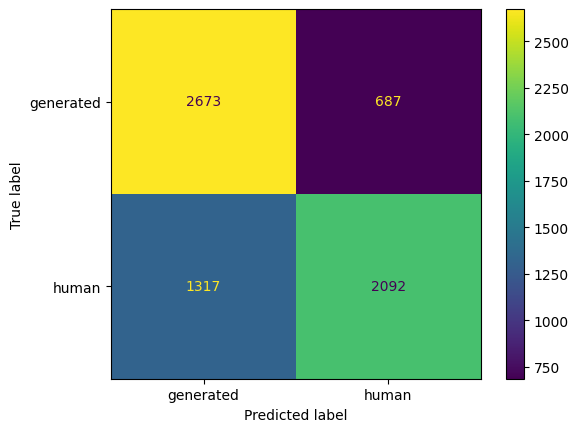

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best CV score: 0.7613753169365146
              precision    recall  f1-score   support

   generated       0.77      0.77      0.77      3360
       human       0.77      0.78      0.78      3409

    accuracy                           0.77      6769
   macro avg       0.77      0.77      0.77      6769
weighted avg       0.77      0.77      0.77      6769



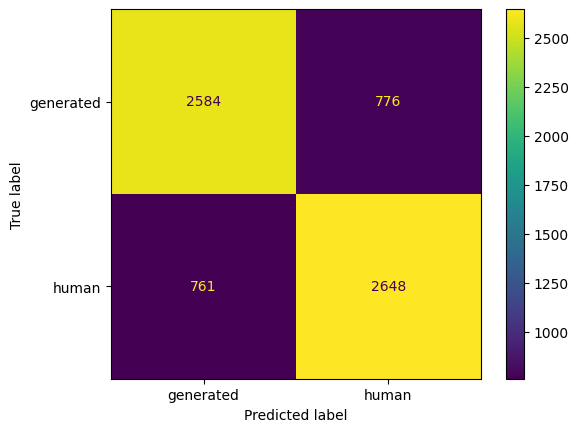

SVC
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best CV score: 0.7623758241758243
              precision    recall  f1-score   support

   generated       0.79      0.78      0.79      3360
       human       0.79      0.80      0.79      3409

    accuracy                           0.79      6769
   macro avg       0.79      0.79      0.79      6769
weighted avg       0.79      0.79      0.79      6769



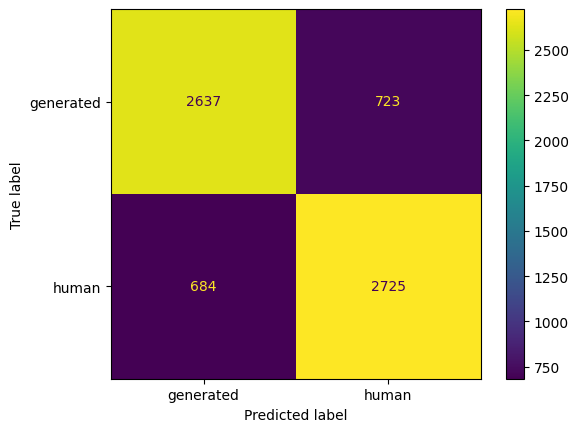

In [35]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [11]:
# Vectorize lemmas
vectorizer = CountVectorizer()
parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x_lem = vectorizer.fit_transform(parsed_df["text_lem"])

# Vectorize POS tags
vectorizer = CountVectorizer()
parsed_df["text_pos"] = parsed_df["features"].apply(lambda x: " ".join([t["pos"] for t in x]))
x_pos = vectorizer.fit_transform(parsed_df["text_pos"])

In [12]:
# Concatenate vectors
x = sps.hstack([x_lem, x_pos])
y = parsed_df["label"]

In [13]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [16]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

In [17]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.6861801222328151
              precision    recall  f1-score   support

   generated       0.64      0.81      0.71      3360
       human       0.74      0.54      0.63      3409

    accuracy                           0.68      6769
   macro avg       0.69      0.68      0.67      6769
weighted avg       0.69      0.68      0.67      6769



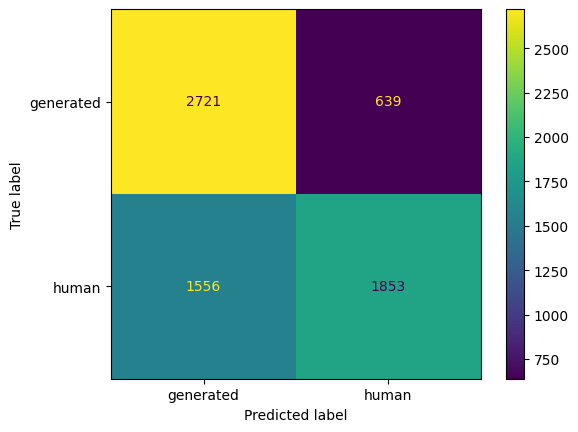

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Best CV score: 0.7782539883877461
              precision    recall  f1-score   support

   generated       0.78      0.77      0.78      3360
       human       0.78      0.79      0.78      3409

    accuracy                           0.78      6769
   macro avg       0.78      0.78      0.78      6769
weighted avg       0.78      0.78      0.78      6769



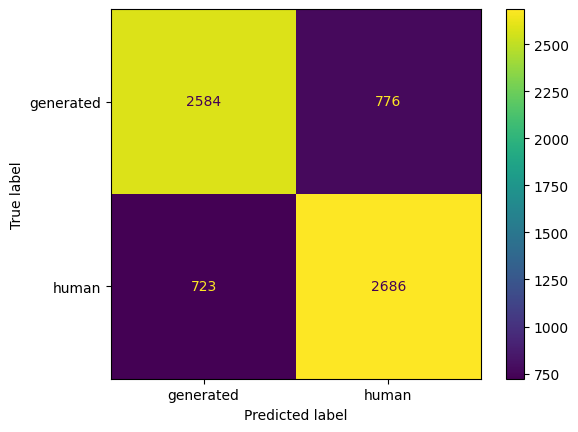

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.8016488821523303
              precision    recall  f1-score   support

   generated       0.82      0.82      0.82      3360
       human       0.82      0.82      0.82      3409

    accuracy                           0.82      6769
   macro avg       0.82      0.82      0.82      6769
weighted avg       0.82      0.82      0.82      6769



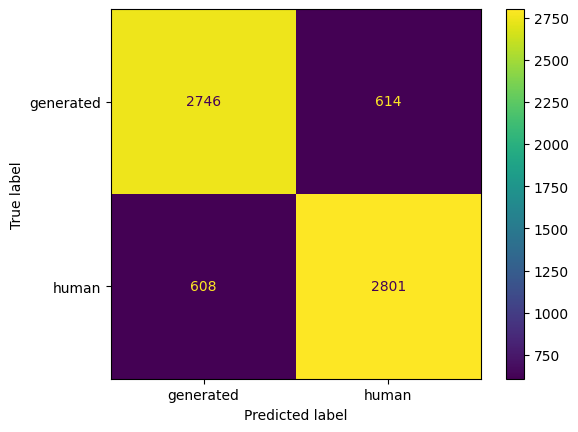

In [18]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)